Like Bert, multilingual transformers used masked language modelling as a pretraining objetive, but they are trained jointly on texts in over one hundred languages
- These multilingual transformers enable **zero-shot cross-lingual** transfer.
    - This mean that a model that is fine-tuned on one language can be applied to others without any further training.
    

In [1]:
!pip install -q datasets transformers accelerate -U -q

In [2]:
from datasets import get_dataset_config_names

xtreme_subsets=get_dataset_config_names('xtreme')

print(f'XTREME has {len(xtreme_subsets)} configurations')

XTREME has 183 configurations


In [3]:
panx_subsets=[s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [4]:
from datasets import load_dataset

load_dataset('xtreme',name='PAN-X.de')


DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [5]:
from collections import defaultdict
from datasets import DatasetDict

In [6]:
langs=['de','fr','it','en']
fracs=[.629,.229,.084,.059]

#Return a DatasetDict if a key doesn't exist

panx_ch=defaultdict(DatasetDict)


for lang,frac,in zip(langs,fracs):
    #Load monolingual corpus

    ds=load_dataset('xtreme',name=f"PAN-X.{lang}")
    #Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split]=(
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac*ds[split].num_rows)))
        )

We use the shuffle() method to make sure we dont accidentally bias our dataset splits, while select() allows us to downsample each corpus according to the values in fracs.

In [7]:
import pandas as pd

pd.DataFrame({lang:[panx_ch[lang]['train'].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


By design, we have more examples in German than all other languages combined, so we'll use it as a starting point from which to perform zero-shot cross-lingual transfer to French Italian, and English

In [8]:
element=panx_ch['de']['train'][0]
for key, value in element.items():
    print(f'{key}:{value}')

tokens:['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags:[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs:['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [9]:
for key, value in panx_ch['de']['train'].features.items():
    print(f"{key}:{value}")



tokens:Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags:Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs:Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


Sequence class psecifies that the field contains a list of features, which is the case of ner_tags corresponds to alist of ClassLabel features.

In [10]:
tags=panx_ch['de']['train'].features['ner_tags'].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


We can use the ClassLabel.int2str() method that we encountered to create a new column in our training set with class names for each tag.We'll use the map() method to retunr a dict with the key corresponding to the new column name and the value as a list of class names

In [11]:
def create_tag_names(batch):
    return{"ner_tags_str":[tags.int2str(idx) for idx in batch['ner_tags']]}

panx_de=panx_ch['de'].map(create_tag_names)

In [12]:
de_example=panx_de['train'][0]
pd.DataFrame([de_example['tokens'],de_example['ner_tags_str']],['Tokens','Tags']
             )

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [13]:
from collections import Counter

split2freqs=defaultdict(Counter)
for split,dataset in panx_de.items():
    for row in dataset['ner_tags_str']:
        for tag in row:
            if tag.startswith('B'):
                tag_type=tag.split('-')[1]
                split2freqs[split][tag_type]+=1
pd.DataFrame.from_dict(split2freqs,orient='index')

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


- Multilingual transformer involve similar architecture and training preocderus as their monolingual counterpartsl, except that the courpu used for pretraining consists of documents in mnay languages.
- A remarkable feature of this approach is that despite receiving no explicit information to differentiate among the languages, the resulting linguistic representations are able to generalize well across langauges for a variety of downstream tasks,

- In some cases this ability to perform corrs-lngual transfer can produce results that are comptetitive with those monolingual models, which circumvents the needo to train one model per language



- To measure the progress of cross-lingual transfer for NER, the [CoNLL-2002](https://huggingface.co/datasets/conll2002) and [CoNLL-2003](https://https://huggingface.co/datasets/conll2003) datasets are often used as a benchmark for English, Dutch, Spanish, and German. This benchmark consists of news articles annotated with the same LOC,PER,and ORG categories as PAN-X but it contains an additional MISC label for miscellaneous entities that do not belong to the previous three groups. Multilingual transformer model usually evaluated in three different ways:

    1.   **en** :Fine-tune on the English Training data then evaluate on each languages test set

    2.   **each** :Fine-tune and evalaute on monolingual test data to measure per-language performance
    
    3.   **all** : Fine-tune on all the training data to evalaute on all on each langauge's test set.







Instead of using A WordPiuece tokenizer, XLM-R uses a tokenizer called SentencePiece that is trained on the raw text of all one hundres languages.


To get a feel for how SentencePiece compares to WordPiece, :

In [14]:
from transformers import AutoTokenizer

bert_model_name='bert-base-cased'
xlmr_model_name='xlm-roberta-base'

bert_tokenizer=AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer=AutoTokenizer.from_pretrained(xlmr_model_name)

In [15]:
#By encoding a small sequence of text we can also retrieve the special tokens that each model used during pretraining


text='Jack Sparrow Loves New York!'

bert_tokens=bert_tokenizer(text).tokens()
xlmr_tokens=xlmr_tokenizer(text).tokens()

In [16]:
print(f"BERT: {bert_tokens}")

print(f"\em\XLMR: {xlmr_tokens}")


BERT: ['[CLS]', 'Jack', 'Spa', '##rrow', 'Loves', 'New', 'York', '!', '[SEP]']
\em\XLMR: ['<s>', '▁Jack', '▁Spar', 'row', '▁Love', 's', '▁New', '▁York', '!', '</s>']


## The Tokenizer Pipeline:
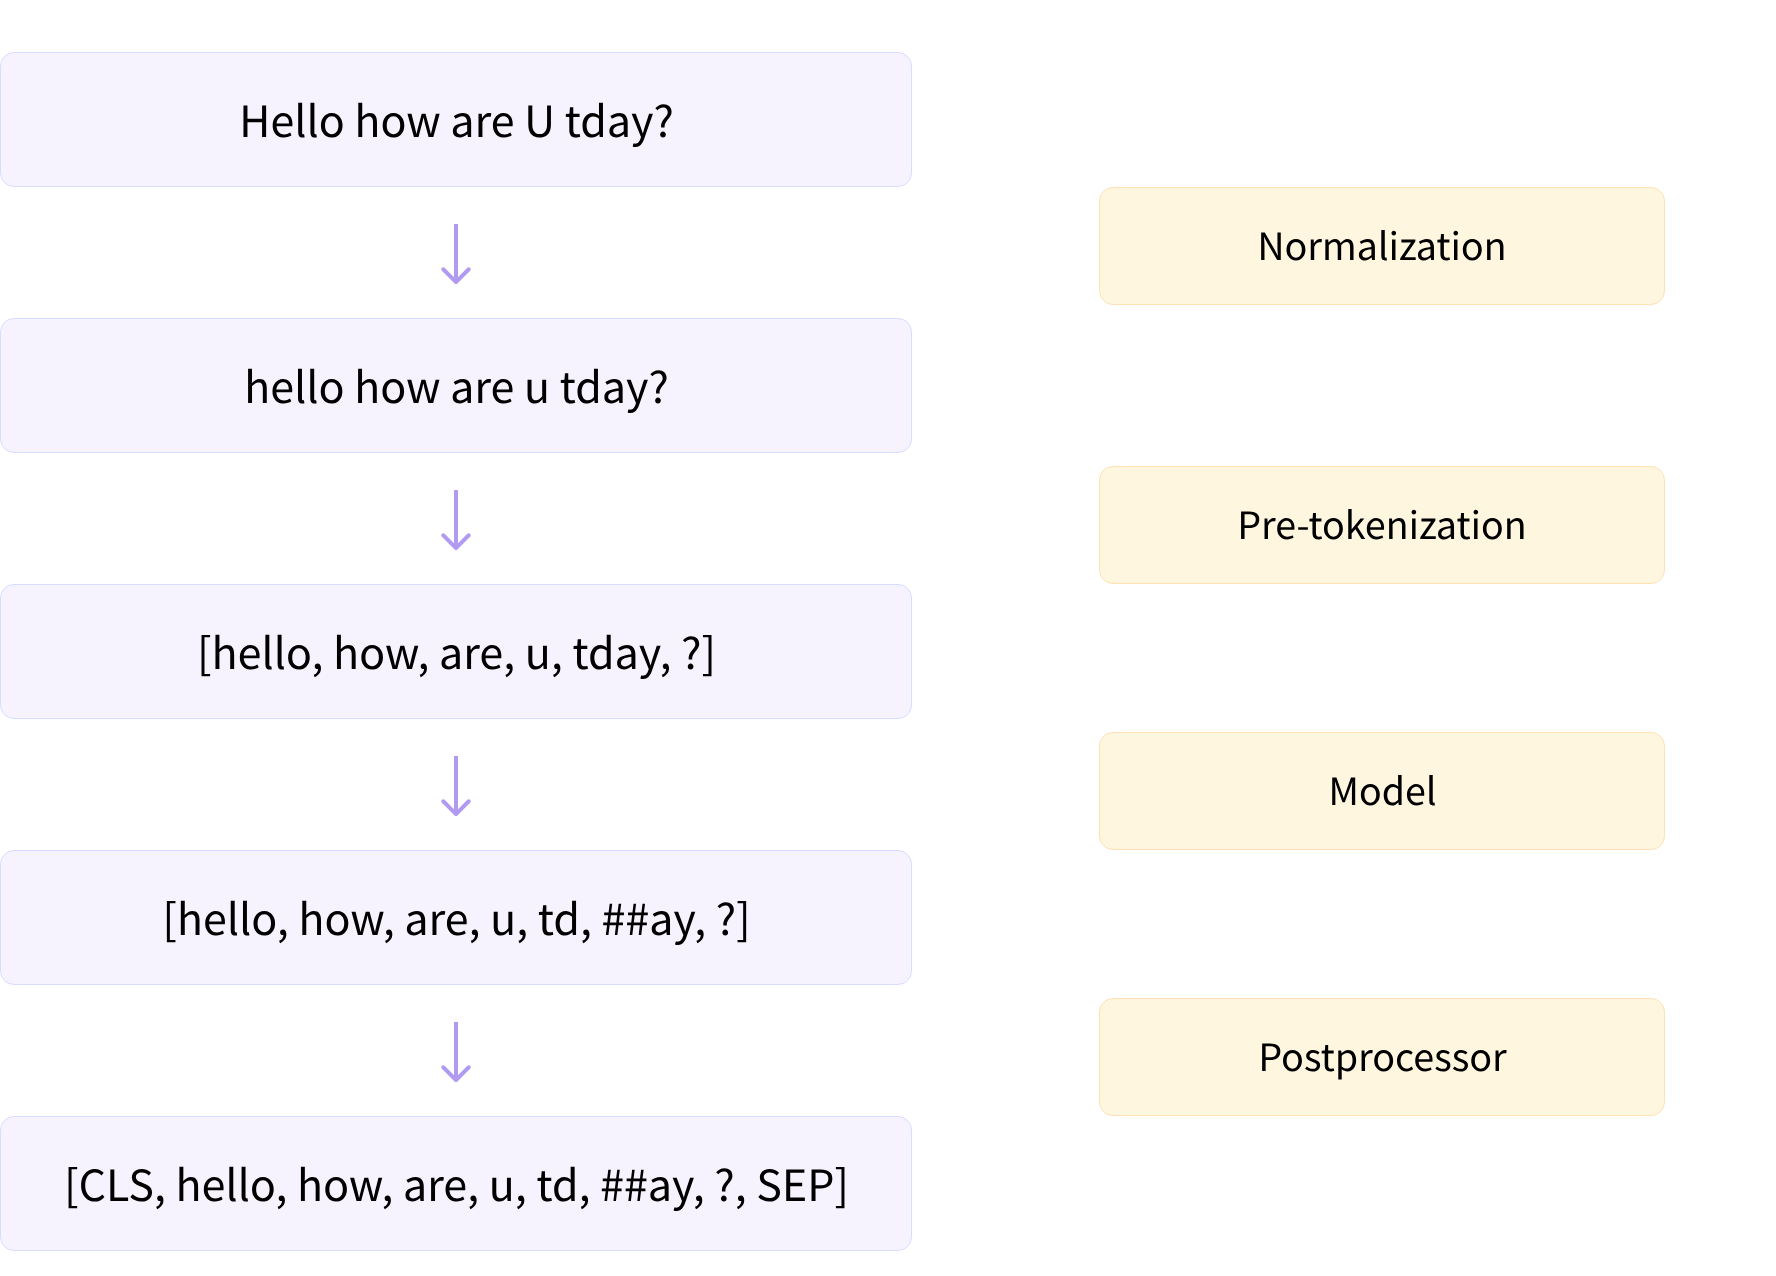

Lets take a closer look at each processing step and illustrate their effect with the example sentence: "Jack Sparrow loves New York!":

- **Normalization**
    - This step is a set of operation you apply to a raw string to make it **cleaner**. Common operations include stripping whitespace and removing accented characters.

    - [**Unicode normalization**](https://unicode.org/reports/tr15/) is another common normalization operation applied by many tokenizers to deal with the fact that there often exist various ways to write the same character
        - This can make two versions of the "same" string (with the same sequence of abstract characters) appear differnt.

        - Unicode normalization shcemes like: **NFC, NFD, NFKC, and NFKD** replace the various ways to write the same character with standard forms.
        
        - Another example of normalization is lowercasing. If the model is expected to only accept and use lowercase characters, this technique can be used to reduce the size of the vocabulary it requires.

    - After normalization, our example strig will look like "jack sparrow loves new york!"
- **Pretokenizatin**
    - This step split a text into smaller objects that give an upper bound to what your tokens will be at the end of training.
        - A good way to think of this is:  the pretokenizer will split your text into "words" and your final tokens will be parts of those words.
            - For the languages that allow this, string can typically be split into words on whitespce and punctuation.
                - For example for our tex: ["jack","sparrow","loves","new","york","!"]
                - These words are  then simpler to split into subwords with  **Byte-Pair Encoding (BPE)** or **Unigram** algorithms in the next step of the pipeline.

        - However splitting into words is not always a trivial and deterministic operation, or even an operaation that makes sense.
            - For instance, in langauges like Chinese, Japanese, or Korean, grouping symbols in semantic unit like Indo-European words can be non determinisitic operation with several equally valid groups.

            - In this case it might not be the best option to pretokenize the text, instead use a **language-specific** library for pretokenization

- **Tokenizer**
    - Once the input texts are normalized and pretokenized, the tokenizer applies a subword splitting model on the words.
    - **This is the part of the pipline that needs to be trained on your corpus** (Or that has been trained, if you are using a pre-trained tokenizer)

    - The role of this model is to split words into subwords to reduce the size of the vocabulary, and try to reduce the number of out-of vocabulary tokens.

    - Several subword tokenization alogrithms exists, including:
        - BPE
        - Unigram
        - WordPiece

    - For instace our example will look like this after the tokenizer model is applied: [jack,spa,rrow,loves,new,york]

        - **Note that**: at this point we nolonger have a list of strings but a list of intergers (inputIDs) ; to keep the exampleillsutrative, we've kep the words but dropepd the quotes to indicate the transformation

- **Postprocessing**
    - Last step of the tokenization pipeline, in which some additional transformations can be applied on the list of tokens0 for instance, adding specail tokens at the begining or end of the input sequence of token indices
        - BERT-style tokenizer would add classifcations and separator tokens: [CLS,jack,spa,rrow,loves,new,york,!,SEP]




# The SentencePiece Tokenizer

- Based ona type of subword segmentation called Unigram and encodes each input text as a sequence of Unicode characters. This last feture is especially useful for multilungaul corpora since it allows SentencePiece to be agnostic to accents,puntuation, and the fact that many langauges, like Japanese, do not have whitespace characters.

- Another feature of SentencePiece is that whitespace is assigned the Unicode symbol U+2581, or the underscore: "**_** "  character also called lower one quarter block character.  
    - This enables SentenPiece to detokenize a sequence without ambiquities and without relying on language-specific pretokenizers. In our example fromm the previous section, for instance, we can see that Word-Piece has lost the information that there is nos white space between "York" and "!". By contrast, SentencePiece preserves the whitespace in the tokenized text so we can convert back to raw text without ambiguity:

In [17]:

print(f"TOKENIZED: {xlmr_tokens}")

"".join(xlmr_tokens).replace(u"\u2581"," ")


TOKENIZED: ['<s>', '▁Jack', '▁Spar', 'row', '▁Love', 's', '▁New', '▁York', '!', '</s>']


'<s> Jack Sparrow Loves New York!</s>'

# Transformers for Named Entity Recognition

- For Text Classification  Bert uses the special CLS token to represent an entire sequence of text.

- This representation is then fed through a fully connected or dense layer to output the distribution of all the discrete label values, as shown:


## Fine-tunning an encoder-based transformer for sequence classification
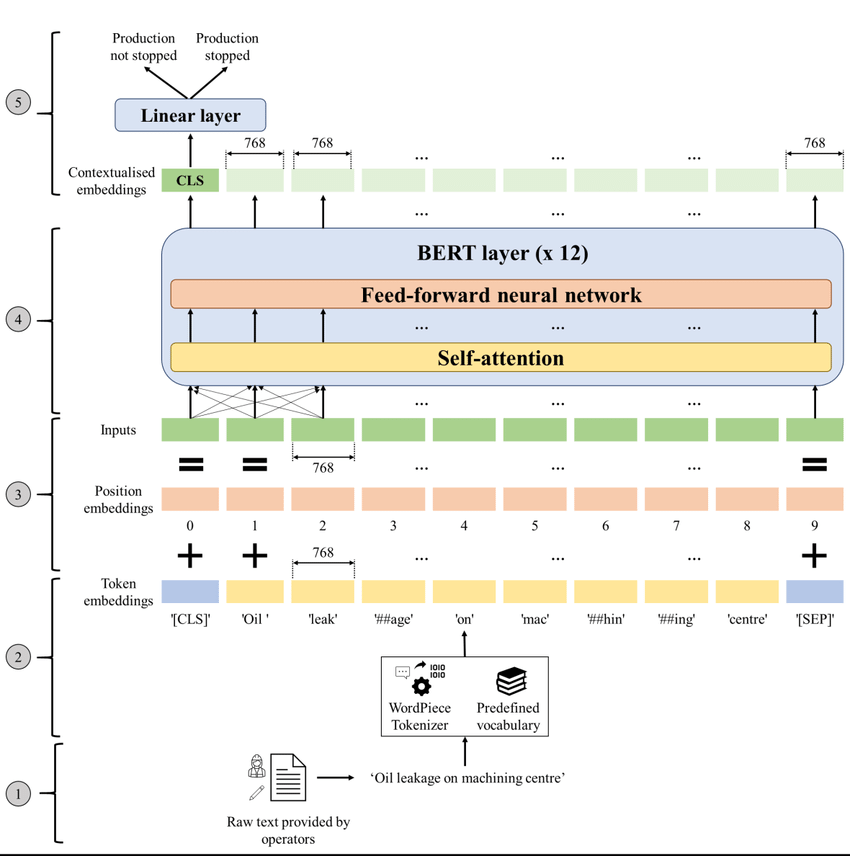



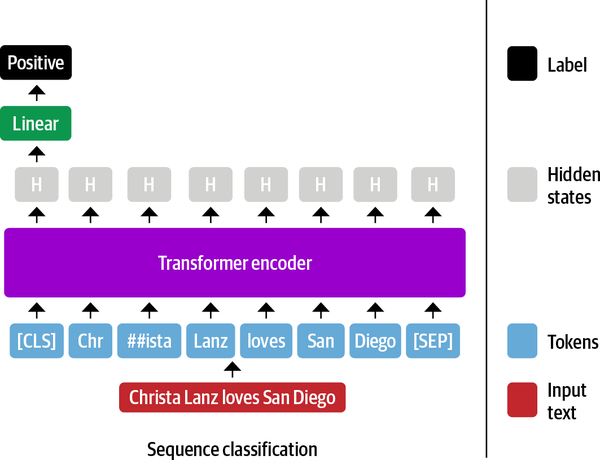

- Bert and other encoder-only transformers take a similar approach for NER, except that the **representation of each individual input token is fed into the same fully connected layer to output the entity that the token belongs to**.

- For this reason, NER is often framed as a token classification task. The proces looks like this:

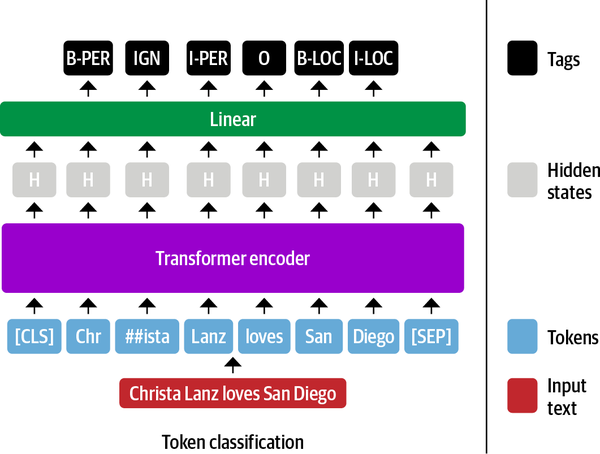





##How should we handle subwords in a token classification task?

- The first name Christa is tokenized into subwords "Chr" and "##ista", so which one(s) should be assinged the B-PER label?


- In the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf) the authors assinged this label to the first subword ("Chr" in our example) and ignored the following ("##ista"). This convention we'll adopt here, and we'll indicate the ignored subwords with IGN.

- We can later easily propagate the predicted label of the firt subword to the subsequent subwords in the post processing step

- We could also have chosen to include the representation of the "##ista" subword by assigning it a copy of the B-LOC label, but this violets the IOB2 format

Transformers is oranized around dedicated classes for each architecture and task.
The model classes associated with different tasks are named according to a:

`<Model Name> For <Task>`
convention or:

` AutomodelFor<Task>`

when using the **AutoModel** classes.



- However, Transformers is designed to enable you to easily extend existing models for your specifc use case:
    - You can load the weights from pretrained Models,and you have access to task-specific helper functions.
    - This lets you build custom models for specific objectives with very little overhead.

🤗Transformers so versatile is the split of the architecture into a body and head.

We've seen that when we switch from pretraining task to the downstream task, we need to replace the loast layer of the model with one tast is suitable for the task/

- **This last layer** is called the model **head** its the part that is **task specific**.

- The rest of the model is called the **body**; it includes the **token embeddings and transformer layers** that are task-agnotic.

- This stucture reflected in the Transformers code as well: the body of a model is implemented in a lass such as BertModel or GPT2Model that returns the hidden states of the last layer.

-  **Task specific models such as BertForMaskedLm or BertForSequenceClassification use the base model and add the necssary head on top of the hidden states.**:
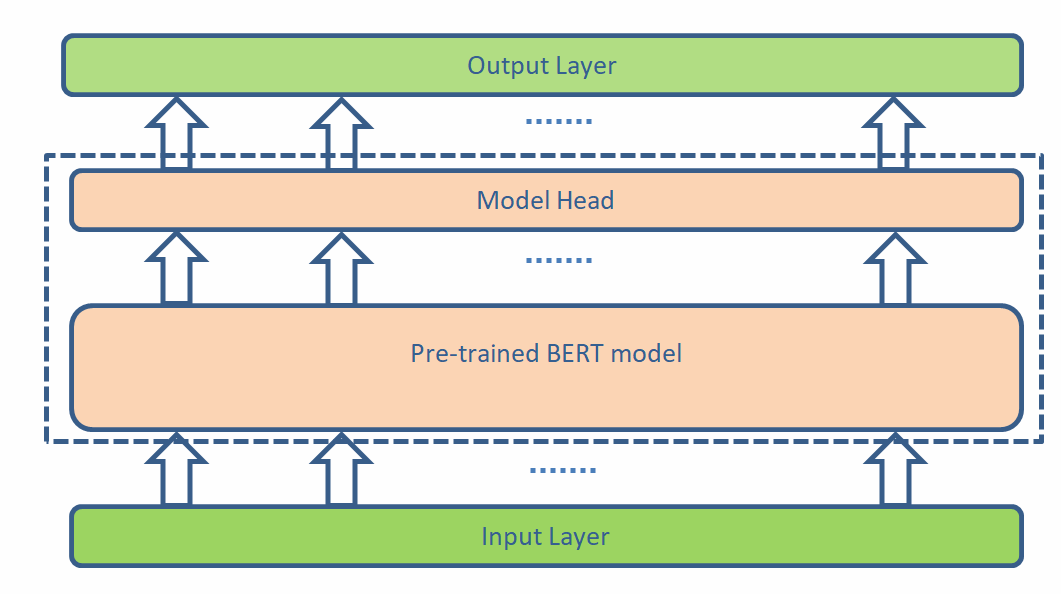


# BERTModel class only contain the body of the model, while the BertFor< Task > classes combine the body with a dedicated head for a given task

In [18]:
# CREATING a Custom Model for Token Classification
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel


class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class=XLMRobertaConfig

    def __init__(self,config):
        super().__init__(config)
        self.num_labels=config.num_labels

        #load model body

        self.roberta=RobertaModel(config,add_pooling_layer=False)

        #Set up token classification head
        self.dropout=nn.Dropout(config.hidden_dropout_prob)
        self.classifier=nn.Linear(config.hidden_size,config.num_labels)

        #load and initialize weights

        self.init_weights
    def forward(self,input_ids=None,attention_mask=None,token_type_ids=None,labels=None,**kwargs):
        #Use model body to get encoder representations
        outputs=self.roberta(input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids,**kwargs)
        ##Apply classifier to encoder representation
        sequence_output=self.dropout(outputs[0])
        logits=self.classifier(sequence_output)
        #Calculate losses
        loss=None

        if labels is not None:
            loss_fct=nn.CrossEntropyLoss()
            loss=loss_fct(logits.view(-1,self.num_labels),labels.view(-1))
        #Return model output object
        return TokenClassifierOutput(loss=loss,logits=logits,hidden_states=outputs.hidden_states,attentions=outputs.attentions)






# def __init__()
1.   **config_class** ensures that the standard XLM-R settings are sued when we intialize a new model

2.   With the `super()` method we call the initialization function of the **RobertaPreTrainedModel** class. This abstract class handles the initialization or loading of pretrained weights.

3. Then we load our model **body**, which is **RobertaModel**,and extend it with our own classification head consisting of a **dropout** and a **standard feed-forward layer.**

4. Note that we set add_pooling_layer=False to ensure all hidden states are returned and not only the one associated with the [CLS] token.

5. Finally we initialize all the weights by calling init_weights() method we inherit from **RobertaPreTrainedModel**, which will load the pretrained weights for the model body and randomly initialize the weights of our token classification head

# def forward()
1. The data is first fed through the model body. There are a number of input variables, but the only ones we need for now are **input_ids** and **attention mask**

2. The hidden state, which is part of the model body output, is then fed through the dropout and classification layers

3. If we also provide labels in the forward pass, we can directly calculate the loss.

4. if there is an attention mask we need to do a little bit more work to make sure we only calcualte the loss of the unmasked tokens.

5. Finally, we wrap all the outputs in a **TokenClassifierOutput** object that allows us to acces elements in the familiar named tuple.

In [19]:
index2tag={idx:tag for idx, tag in enumerate(tags.names)}
tag2index={tag:idx for idx,tag in enumerate(tags.names)}


In [20]:
from transformers import AutoConfig

xlmr_config=AutoConfig.from_pretrained(xlmr_model_name,num_labels=tags.num_classes,id2label=index2tag,label2id=tag2index)


In [21]:
import torch

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xlmr_model=(XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name,config=xlmr_config).to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
input_ids=xlmr_tokenizer.encode(text,return_tensors='pt')
pd.DataFrame([xlmr_tokens,input_ids[0].numpy()],index=['Tokens',"Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁Love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,11954,7,2356,5753,38,2


Finally we need to pass the inputs to the model and extract the prediction by taking the argmax to get the most likely class per token

In [67]:
outputs=xlmr_model(input_ids.to(device)).logits
predictions=torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [136]:
print(predictions)

tensor([[4, 6, 6, 6, 6, 6, 6, 6, 6, 4]])


In [68]:
preds=[tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens,preds],index=['Tokens',"Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁Love,s,▁New,▁York,!,</s>
Tags,I-ORG,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-ORG


Our token classification layer with random wiehgts leaves a lot to be desired:let's fine-tune on same labeled data to make it better.


But before lets wrap teh preceding steps into a helper function

In [186]:
def tag_text(text,tags,model,tokenizer):
    #Get tokens with special characters
    tokens=tokenizer(text).tokens()
    #Encode the sequence into IDS
    input_ids=xlmr_tokenizer(text,return_tensors='pt').input_ids.to(device)
    #Get predictions as distribution over 7 possible classes
    outputs=model(input_ids)[0]

    #Take argmax to get most likely class per token
    predictions=torch.argmax(outputs, dim=2)

    #Convert to Dataframe
    preds=[tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens,preds],index=['Tokens',"Tags"])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [84]:
words,labels=de_example['tokens'],de_example['ner_tags']

In [85]:
tokenized_input=xlmr_tokenizer(de_example['tokens'],is_split_into_words=True)
tokens=xlmr_tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
pd.DataFrame([tokens],index=['Tokens'])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In this example we can see that the tokenizer has split Einwohnern into two subwrods" __Einwohner" and "n" since we're following the convention that only "__Einwohner" should be associated with the B-LOC label,

- We need to  mak the subword representations after the first word:
    - Fortunately, tokenized_input is a classs that contain a word_ids() function that can help us achieve that:



In [86]:
word_ids=tokenized_input.word_ids()
pd.DataFrame([tokens,word_ids],index=["Tokens","Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


We can see that word_ids has mapped each subword to the corresponding index in the worrds sequence, so the first subword,"_2000", is assigned the indx,0
while "__Einwohner" and "n" are assigned the index 1

- We can also see that special tokens like < s>  < /s> are maped to **None**
- Now let set -100 as the label for these special tokens and the subword we wish to mask during training:



In [87]:
previous_word_idx=None

label_ids=[]

for word_idx in word_ids:
    if word_idx is None or word_idx==previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx=word_idx

labels=[index2tag[l] if l != -100 else "IGN" for l in label_ids]
index=['Tokens',"Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens,word_ids,label_ids,labels],index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


We choose -100 as the ID to mask subword representations:
- Pytorch the cross-entropy loss class : torch.nn.CrossEntropyLoss has an attribute called ignore_index whose value is -100.

- This index is ingored during training so we can use it to ignore the tokens asociated with consecutive subwords

In [88]:
def tokenize_and_align_labels(examples):
    tokenized_inputs=xlmr_tokenizer(examples['tokens'],truncation=True,is_split_into_words=True)

    labels=[]

    for idx,label in enumerate(examples['ner_tags']):
        word_ids=tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx=None
        label_ids=[]
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx=word_idx
        labels.append(label_ids)
    tokenized_inputs['labels']=labels
    return tokenized_inputs

In [89]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels,batched=True,remove_columns=['langs','ner_tags','tokens'])

In [90]:
panx_de_encoded=encode_panx_dataset(panx_ch['de'])

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

#Perfromance Measures

- Evaulatin a NER model is similar to evaluating a text classification model, and it is common to report results for precision, recall, and F1-score.

In [91]:
!pip install seqeval -q

In [64]:
from seqeval.metrics import classification_report

y_true=[["O","O","O","B-MISC","I-MISC","I-MISC","0"],["B-PER","I-PER","0"]]
y_pred=[["O","O","B-MISC","I-MISC","I-MISC","I-MISC","O"],["B-PER","I-PER","O"]]

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [142]:
import numpy as np

def align_predictions(predictions, label_ids):
    print(f"Prediction Shape:{predictions.shape}")
    preds=np.argmax(predictions, axis=2)
    batch_size,seq_len=preds.shape
    labels_list,preds_list=[],[]

    for batch_idx in range(batch_size):
        example_labels,example_preds=[],[]
        for seq_idx in range(seq_len):
            # Ignore label IDS= -100
            if label_ids[batch_idx, seq_idx] !=-100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list,labels_list

## Here we fine-tune the base model on the German subset of PAN-X and tehn evaluate its zero-shot cross-lingual perofrmance on French,Italian,English.

In [143]:
# Fine-Tuning XLM-RoBERTa
from transformers import TrainingArguments

num_epochs=3
batch_size=24
logging_steps=len(panx_de_encoded['train'])//batch_size
model_name=F"{xlmr_model_name}-finetuned-panx-de"
training_args=TrainingArguments(output_dir=model_name
                                ,log_level='error'
                                ,num_train_epochs=num_epochs
                                ,per_device_train_batch_size=batch_size
                                ,per_device_eval_batch_size=batch_size
                                ,evaluation_strategy='epoch'
                                ,save_steps=1e6
                                ,weight_decay=.01
                                ,disable_tqdm=False
                                ,logging_steps=logging_steps
                                ,push_to_hub=True)

In [140]:
from huggingface_hub import notebook_login

notebook_login()

In [144]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    print(f"compute_metrics eval predictions:{eval_pred.predictions}")
    y_pred,y_true=align_predictions(eval_pred.predictions,eval_pred.label_ids)

    return{"f1":f1_score(y_true,y_pred)}

The final step is to define a data collator so we can pad each input sequence to the largest sequence length in a batch

In [145]:
from transformers import DataCollatorForTokenClassification

data_collator=DataCollatorForTokenClassification(xlmr_tokenizer)



- Padding the labels is necessary becasue, unlike in a text classifcation task, the labels are also sequences.
- Label sequences are padded with the value -100

In [146]:
def model_init():
    return(XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name,config=xlmr_config).to(device))

In [147]:
from transformers import Trainer

trainer=Trainer(
     model_init=model_init
    ,args=training_args
    ,data_collator=data_collator
    ,compute_metrics=compute_metrics
    ,train_dataset=panx_de_encoded['train']
    ,eval_dataset=panx_de_encoded['validation']
    ,tokenizer=xlmr_tokenizer
)
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.275200,0.160831,0.823295
2,0.130500,0.138654,0.845734
3,0.082100,0.136722,0.859544


compute_metrics eval predictions:[[[-9.6139789e-02 -6.6815907e-01 -5.0049454e-01 ... -1.9254279e-01
    2.9777125e-01 -1.3149207e+00]
  [-5.8454770e-01  1.0212559e+00 -2.3008621e+00 ...  2.6156168e+00
   -2.2358274e+00 -3.2344303e+00]
  [-1.0245411e+00 -2.3408833e+00  1.4635921e-03 ... -1.2865945e+00
    1.2855123e+00 -2.9306126e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 6.1920816e-01 -3.8061297e-01 -5.8662748e-01 ...  2.4901181e-02
   -8.1774242e-02 -1.1597100e+00]
  [ 8.2849569e+00 -1.8780746e+00 -1.9851615e+00 ... -1.3646864e+00
   -1.4536142e+00 -3.4346876e+00]
  [ 7.8409367e+00 -1.8481619e+00 -1.9315178e+00 ... -1.4283894e+00
   -1.3333920e+00 -3.2793286e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

TrainOutput(global_step=1575, training_loss=0.16241847263442147, metrics={'train_runtime': 2728.0117, 'train_samples_per_second': 13.834, 'train_steps_per_second': 0.577, 'total_flos': 864573754419648.0, 'train_loss': 0.16241847263442147, 'epoch': 3.0})

In [149]:
trainer.push_to_hub(commit_message="Training Completed!")

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

'https://huggingface.co/ckandemir/xlm-roberta-base-finetuned-panx-de/tree/main/'

In [189]:
text_de="Jeff Dean ist ein informatiker bei Google inKlifornien"
tag_text(text_de,tags,trainer.model,xlmr_tokenizer)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁informatik,er,▁bei,▁Google,▁in,K,li,for,ni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,B-LOC,B-LOC,I-LOC,O,O


There are several Failute modes where it might look like the model is performing well, while in practice it has some serious flaws. Examples where training can fail:
- We might accidentally mask too many tokens and also mask some of our labels to get a really promising loss drop
- The compute_metrics() function might have a bug that overestimates the tru performance
- We might incluide the zero class or 0 entity in NER as a normal class, which will heavily skew the accuracy and F-sore since it is the majority class by a large margin

In [160]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    #Convert dict of lists to list of dicsts suitable for data collator
    features=[dict(zip(batch, t)) for t in zip(*batch.values())]

    #Pad inputs and labels and put all tensors on device

    batch=data_collator(features)

    input_ids=batch["input_ids"].to(device)

    attention_mask=batch['attention_mask'].to(device)

    labels=batch['labels'].to(device)

    with torch.no_grad():
        #Pass datathorugh model
        output=trainer.model(input_ids, attention_mask)
        #logit.size:[batch_size,sequnce_length,classes]
        #Predict class with largest logit value on classes axis

        predicted_label=torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    num_classes = output.logits.shape[-1]
    loss=cross_entropy(
         output.logits.view(-1,num_classes)
        ,labels.view(-1)
        ,reduction="none"
        )

    #Unflatten batch dimension and convert to numpy array

    loss=loss.view(len(input_ids), -1).cpu().numpy()

    return {'loss':loss, 'predicted_label':predicted_label}

In [161]:
valid_set=panx_de_encoded['validation']
valid_set=valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df=valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [162]:
index2tag[-100]="IGN"
df['input_tokens']=df["input_ids"].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df['predicted_label']=df['predicted_label'].apply(lambda x:[index2tag[i] for i in x])
df['labels']=df['labels'].apply(lambda x:[index2tag[i] for i in x])
df['loss']=df.apply(lambda x: x['loss'][:len(x['input_ids'])],axis=1)

df['predicted_label']=df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])],axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.027732512, 0.0, 0.015519445, 0.0171922...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [163]:
df_tokens=df.apply(pd.Series.explode)
df_tokens=df_tokens.query("labels != 'IGN'")
df_tokens['loss']=df_tokens['loss'].astype(float).round(2)
df_tokens.head(7)


,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.03,B-ORG,▁Ham
0,15,1,I-ORG,0.02,I-ORG,▁(
0,16104,1,I-ORG,0.02,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.01,B-LOC,▁Luz
1,10,1,I-ORG,1.17,I-LOC,▁a


In [164]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count","mean","sum"])
    .droplevel(level=0,axis=1) # Get rid of multi-level columns
    .sort_values(by='sum',ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁von,▁der,▁(,▁und,▁/,▁),▁'',▁A
count,6066,989,808,1388,246,1171,163,246,2898,125
mean,0.03,0.13,0.15,0.09,0.39,0.08,0.58,0.37,0.02,0.44
sum,211.7,132.35,123.1,120.53,95.87,95.45,94.75,91.05,70.89,54.51


We can obser several patterns:
- Whitespace token has the highest total loss, which is not suprising isnce it is also the most common token in the list. However, its mean loss is much lower than the other tokens in the list.
    - This means that the model doesn't struggle to classify it
- Word like 'in', 'von','der',and 'under' appear relatively frequently. They often appear together with named entities and are sometimes aprt fo them, which explains why the model mix them up

- Parntheses,slashes,and capital letters at the beginning of words are rarer, but have a relatively high average loss.


In [166]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count","mean","sum"])
    .droplevel(level=0,axis=1) # Get rid of multi-level columns
    .sort_values(by='mean',ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.63,0.59,0.51,0.32,0.27,0.2,0.03
sum,1692.34,856.72,1934.62,1026.87,783.78,813.21,1291.65


- B-ORG has the highest average loss, which mean that determining the beginning of an organization poses a challenge to our model

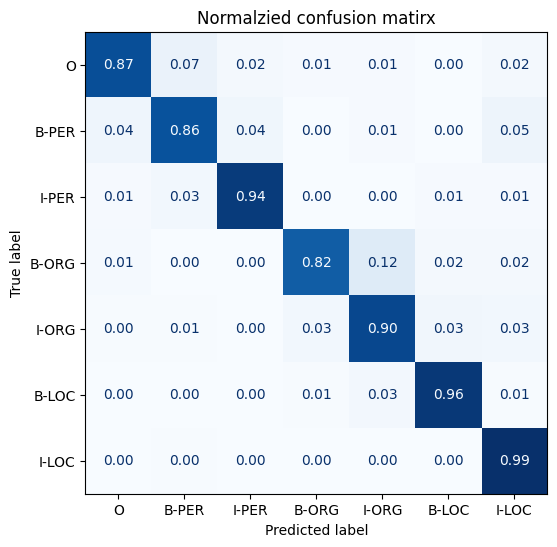

In [169]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds,y_true,labels):
    cm=confusion_matrix(y_true,y_preds,normalize='true')
    fig,ax=plt.subplots(figsize=(6,6))
    disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
    disp.plot(cmap="Blues",values_format=".2f",ax=ax,colorbar=False)
    plt.title("Normalzied confusion matirx")
    plt.show()

plot_confusion_matrix(df_tokens['labels'],df_tokens['predicted_label'],tags.names)

Now that we've examined the errors at the token level, lets move on and look at sequences with high losses.

- For this calculation we'll revist our 'unexploded' DataFrame and calculate the toal loss by summing over the loss per token.

In [172]:
def get_samples(df):
    for _, row in df.iterrows():
        labels,preds,tokens,losses=[],[],[],[]
        for i, mask in enumerate(row['attention_mask']):
            if i not in {0,len(row['attention_mask'])}:
                labels.append(row['labels'][i])
                preds.append(row['predicted_label'][i])
                tokens.append(row['input_tokens'][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp=pd.DataFrame({'tokens':tokens
                             ,'labels':labels
                             ,'preds':preds
                             ,"losses":losses
                             }).T

        yield df_tmp

df['total_loss']=df['loss'].apply(sum)
df_tmp=df.sort_values(by='total_loss',ascending=False).head(3)


for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,2.77,0.00,0.00,0.00,10.96,11.16,7.62,8.24,8.61,0.00,8.69,8.83,0.00,9.77,9.51,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,7.36,0.00,0.00,6.93,9.49,9.63,7.08,0.00,7.36,8.56,6.89,5.73,6.48,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,6.74,6.34,6.20,0.00,6.01,0.00,6.07,0.00,5.91,5.67,6.22,6.11,6.11,5.85,0.00


In [173]:
def get_f1_score(trainer,dataset):
    return trainer.predict(dataset).metrics['test_f1']

In [174]:
f1_scores=defaultdict(dict)
f1_scores['de']['de']=get_f1_score(trainer,panx_de_encoded['test'])

print(f"F1-score of [de] model on [de ] dataset:{f1_scores['de']['de']:.3f}")

compute_metrics eval predictions:[[[ 1.3260931e-01 -1.3053707e+00 -4.2371592e-01 ...  5.7806849e-01
    2.8383296e+00 -1.3614517e+00]
  [ 9.1253948e+00 -1.5488122e+00 -1.5599923e+00 ... -1.4660342e+00
   -1.8498046e+00 -3.2909801e+00]
  [ 8.9726543e+00 -1.5098932e+00 -1.4606042e+00 ... -1.5871506e+00
   -1.7489078e+00 -3.2757452e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 2.3530464e+00  1.5913521e-01 -6.2641954e-01 ... -1.7474847e+00
   -1.7758492e+00 -2.9747939e+00]
  [ 9.3351831e+00 -1.5941106e+00 -1.3678994e+00 ... -1.8449177e+00
   -1.3548347e+00 -3.3649406e+00]
  [-2.0015409e+00  4.1505399e+00 -1.5894578e+00 ...  2.0618817e-01
   -3.7484117e+00 -2.4692867e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

In [187]:
text_fr="Jeff Dean est informaticien chez Google en Califronie"
tag_text(text_fr,tags, trainer.model ,xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,fro,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [188]:
def evaluate_lang_performance(lang,trainer):
    panx_ds=encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer,panx_ds['test'])

f1_scores['de']['fr']=evaluate_lang_performance('fr',trainer)

print(f"F1-score of [de] model on [fr ] dataset:{f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

compute_metrics eval predictions:[[[-2.69143522e-01  2.30989790e+00  1.22452915e+00 ... -7.18918741e-01
   -1.35600185e+00 -2.65616012e+00]
  [ 9.27077293e+00 -1.39826632e+00 -1.16723454e+00 ... -2.08783984e+00
   -1.84942591e+00 -3.46519852e+00]
  [ 9.22904968e+00 -1.36755884e+00 -1.12126899e+00 ... -2.09318733e+00
   -1.76414335e+00 -3.49639511e+00]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[ 2.60936165e+00 -1.01767588e+00 -2.07840466e+00 ...  1.35505462e+00
    1.86862677e-01 -2.30642605e+00]
  [ 8.41971588e+00 -1.55437458e+00 -2.70064068e+00 ...  3.27671692e-03
   -2.10399008e+00 -3.77819467e+00]
  [ 8.60929871e+00 -1.64139915e+00 -2.55256677e+00 ... -3.69525552e-01
   -1.50789618e+00 -3.70315552e+

In [190]:

f1_scores['de']['it']=evaluate_lang_performance('it',trainer)

print(f"F1-score of [de] model on [it ] dataset:{f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

compute_metrics eval predictions:[[[ 2.0331624e+00 -1.3840365e+00 -3.6342618e-01 ... -1.1573530e+00
    2.3726775e-01 -3.1055746e+00]
  [ 9.2362499e+00 -1.7530299e+00 -1.8567767e+00 ... -1.5008371e+00
   -1.5247014e+00 -3.7492046e+00]
  [ 9.0936680e+00 -1.9734335e+00 -1.7680475e+00 ... -1.5695997e+00
   -1.4737859e+00 -3.7645195e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 3.4647155e+00 -1.7562464e+00 -1.9087067e+00 ...  1.3750343e+00
    1.6380193e+00 -2.5223584e+00]
  [ 8.9391975e+00 -1.6152318e+00 -1.8230190e+00 ... -7.4615991e-01
   -1.4352105e+00 -3.2927313e+00]
  [ 9.2554607e+00 -2.0168204e+00 -1.7038070e+00 ... -1.0687569e+00
   -1.1926861e+00 -3.6148643e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

In [191]:

f1_scores['de']['en']=evaluate_lang_performance('en',trainer)

print(f"F1-score of [de] model on [en ] dataset:{f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

compute_metrics eval predictions:[[[ 4.4548531e+00 -6.5796477e-01 -1.8139429e+00 ... -3.9720304e-02
   -1.3278857e+00 -2.8179555e+00]
  [ 9.4342403e+00 -1.8323109e+00 -1.9183969e+00 ... -1.4405048e+00
   -1.2438571e+00 -3.7478538e+00]
  [ 9.2781029e+00 -1.8664094e+00 -2.0047610e+00 ... -1.1709194e+00
   -1.2259036e+00 -3.8761573e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[-4.1680062e-01  2.5244160e+00  3.2509658e+00 ... -1.4137006e+00
   -1.6098902e+00 -2.0713005e+00]
  [-1.2838855e+00  7.9918146e+00 -9.2877990e-01 ... -7.2634512e-01
   -3.2804344e+00 -2.2555137e+00]
  [-1.6887596e+00 -7.6367313e-01  7.8454518e+00 ... -2.2040541e+00
   -7.7014947e-01 -2.4354885e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

# Having fine-tuned on German and performed zero-shot transfer to French and English, lets next examine when it makes sense to fine tune directly on the target language

In [196]:
def train_on_subset(dataset,num_samples):
    train_ds=dataset['train'].shuffle(seed=42).select(range(num_samples))
    valid_ds=dataset['validation']
    test_ds=dataset['test']

    logging_steps = len(train_ds)//batch_size

    training_args=TrainingArguments(output_dir=model_name
                                ,log_level='error'
                                ,num_train_epochs=num_epochs
                                ,per_device_train_batch_size=batch_size
                                ,per_device_eval_batch_size=batch_size
                                ,evaluation_strategy='epoch'
                                ,save_steps=1e6
                                ,weight_decay=.01
                                ,disable_tqdm=False
                                ,logging_steps=logging_steps
                                ,push_to_hub=True)

    trainer=Trainer(model_init=model_init
                    ,args=training_args
                    ,data_collator=data_collator
                    ,compute_metrics=compute_metrics
                    ,train_dataset=train_ds
                    ,eval_dataset=valid_ds
                    ,tokenizer=xlmr_tokenizer
                    )
    trainer.train()

    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")

    f1_score=get_f1_score(trainer,test_ds)
    return pd.DataFrame.from_dict({
        "num_samples":[len(train_ds)],"f1_score":[f1_score]
    })

In [197]:
panx_fr_encoded=encode_panx_dataset(panx_ch['fr'])

In [198]:
from dataclasses import replace
training_args = replace(training_args,push_to_hub=False )

In [199]:
metrics_df=train_on_subset(panx_fr_encoded,250)

metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.808900,1.363862,0.145545
2,1.248800,1.114431,0.149447
3,1.075100,1.024090,0.194650


compute_metrics eval predictions:[[[-1.6219541e-02 -3.3688462e-01 -7.4993914e-01 ...  2.4992982e-01
   -7.0957065e-02 -9.4157845e-02]
  [ 5.1673198e-01 -3.5251492e-01 -5.1963019e-01 ... -6.1593413e-02
   -1.9986767e-01 -1.1341324e+00]
  [ 4.6673763e-01 -4.9033237e-01 -5.5301076e-01 ... -1.5821385e-01
   -1.1653091e-01 -9.0536112e-01]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[-6.9043323e-02 -3.8365203e-01 -7.4955928e-01 ...  2.7304524e-01
    1.5550345e-02 -1.4711940e-01]
  [ 1.5458072e+00 -1.1816268e+00  2.0519760e-01 ... -4.9809128e-01
    5.5978316e-01 -1.8876376e+00]
  [ 1.4313755e+00 -1.5914359e+00 -2.1664068e-01 ... -4.9660063e-01
    7.2733176e-01 -2.0358005e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

compute_metrics eval predictions:[[[-8.1209183e-02 -2.6131877e-01 -7.6858705e-01 ...  2.9320860e-01
   -9.1697037e-02 -1.6002649e-01]
  [ 4.8100424e+00 -1.0704106e+00 -8.5152489e-01 ... -1.1389537e+00
   -6.8755436e-01 -2.6607277e+00]
  [ 5.0316529e+00 -1.0373832e+00 -7.4957371e-01 ... -1.1719922e+00
   -5.3548312e-01 -2.6240413e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[-5.4799065e-02 -3.2310420e-01 -7.7378196e-01 ...  3.2703593e-01
   -4.5102678e-02 -1.8223733e-01]
  [ 2.5324316e+00 -1.3140475e+00 -3.9359334e-01 ... -3.1945270e-01
   -3.4912646e-01 -2.4269238e+00]
  [ 2.3500292e+00 -8.0352879e-01 -7.5704372e-01 ...  2.7273804e-01
    1.5391357e-01 -2.5272245e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

,num_samples,f1_score
0,250,0.179742


In [200]:
for num_samples in [500,1000,2000,4000]:
    metrics_df=metrics_df.append(
        train_on_subset(panx_fr_encoded,num_samples),ignore_index=True
    )

Epoch,Training Loss,Validation Loss,F1
1,1.501500,1.070496,0.164805
2,0.898700,0.707069,0.586939
3,0.637900,0.582168,0.613833


compute_metrics eval predictions:[[[ 2.27469131e-01 -2.82743692e-01 -7.11454690e-01 ...  1.34679943e-01
    3.34136784e-02 -2.58882761e-01]
  [ 1.74685657e-01 -1.18011087e-02 -1.26442999e-01 ...  2.05593288e-01
   -2.91127145e-01 -1.47101355e+00]
  [ 2.80832589e-01 -6.07957207e-02 -1.23994559e-01 ... -1.61655813e-01
   -1.00990951e-01 -1.19088268e+00]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[-1.35176182e-02 -3.08554441e-01 -7.42771626e-01 ...  2.42309466e-01
   -1.62256360e-02 -2.08281845e-01]
  [ 3.22413278e+00 -5.94696879e-01  3.30613971e-01 ... -8.25710952e-01
    7.84141719e-02 -2.13093376e+00]
  [ 2.98851871e+00 -5.57642698e-01  4.03302133e-01 ... -7.84809411e-01
    2.64023721e-01 -2.07404590e+

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

compute_metrics eval predictions:[[[ 3.0682564e-02 -4.8578635e-02 -7.2948223e-01 ...  2.7985466e-01
   -1.5308359e-01 -2.8966314e-01]
  [ 5.9431400e+00 -6.8749672e-01 -6.2913388e-01 ... -1.2783966e+00
   -5.5108005e-01 -2.6935542e+00]
  [ 5.9595819e+00 -6.7110342e-01 -6.0236615e-01 ... -1.2489420e+00
   -4.4676754e-01 -2.6739984e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 1.1502199e-01 -3.5980380e-01 -9.0743339e-01 ...  3.5713780e-01
    1.3056853e-01 -3.5562909e-01]
  [ 3.9460754e+00 -1.4057175e+00 -5.8735061e-01 ... -1.5360886e-01
   -4.5232934e-01 -2.7604725e+00]
  [ 4.0677676e+00 -9.3462056e-01 -4.4715768e-01 ...  1.1122167e-02
    6.3861507e-01 -2.9257650e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

<ipython-input-200-65af58ecc799>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df=metrics_df.append(


Epoch,Training Loss,Validation Loss,F1
1,1.215300,0.611082,0.586675
2,0.473000,0.398410,0.734284
3,0.312500,0.380383,0.760052


compute_metrics eval predictions:[[[ 2.91188061e-03 -2.17395365e-01 -7.61538267e-01 ...  2.96582907e-01
   -6.83056042e-02 -2.59215772e-01]
  [-1.43019128e+00  2.90169954e-01 -2.11960487e-02 ...  2.28937769e+00
   -3.13317329e-01 -2.58399677e+00]
  [-1.38654089e+00 -3.48948389e-01  3.68917465e-01 ...  9.32682574e-01
    5.98763764e-01 -2.51650453e+00]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[-9.78218317e-02 -4.40284848e-01 -8.12071919e-01 ...  2.51051545e-01
    1.02804728e-01 -4.20029014e-01]
  [ 4.63216114e+00 -1.29078478e-02 -1.12624228e+00 ... -1.81373969e-01
   -1.30742753e+00 -2.72999811e+00]
  [ 4.84422779e+00 -1.86214298e-01 -1.09136879e+00 ... -4.67741907e-01
   -9.63764489e-01 -2.84406948e+

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

compute_metrics eval predictions:[[[-4.3562278e-02 -1.1819812e-01 -7.3409718e-01 ...  2.9138571e-01
   -1.8354397e-01 -2.4886601e-01]
  [ 6.5058069e+00 -1.2042065e+00 -1.6070638e+00 ... -1.0229746e+00
   -1.3468850e+00 -2.6004741e+00]
  [ 6.5823040e+00 -1.1379478e+00 -1.6225524e+00 ... -1.0000973e+00
   -1.3688133e+00 -2.6247201e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 1.9168645e-02 -2.4322009e-01 -8.1832683e-01 ...  4.0274513e-01
   -3.8896933e-02 -2.5909615e-01]
  [ 4.3864222e+00 -7.7141124e-01 -1.5208702e+00 ...  1.0930163e+00
   -7.2021353e-01 -2.4437451e+00]
  [ 4.5166903e+00 -6.8083990e-01 -1.6206475e+00 ...  8.2816124e-01
    3.9094156e-01 -2.7886252e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

<ipython-input-200-65af58ecc799>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df=metrics_df.append(


Epoch,Training Loss,Validation Loss,F1
1,0.838300,0.425616,0.725586
2,0.323300,0.340230,0.790736
3,0.208000,0.355107,0.804065


compute_metrics eval predictions:[[[ 2.54160464e-02 -6.94153905e-02 -6.53207839e-01 ...  2.87641466e-01
   -2.43916780e-01 -3.11912805e-01]
  [-1.42995119e+00  4.87626934e+00 -9.29242790e-01 ...  1.16752005e+00
   -2.53233910e+00 -2.17426157e+00]
  [-1.07083106e+00  3.54215789e+00  1.58715606e+00 ... -1.04418373e+00
   -1.42637181e+00 -2.56884599e+00]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[ 2.48850882e-03 -2.54585147e-01 -6.79944336e-01 ...  1.77732617e-01
   -1.29745394e-01 -3.24730217e-01]
  [ 6.11949635e+00 -1.10713983e+00 -8.51831913e-01 ... -6.19224787e-01
   -1.51443934e+00 -2.94560146e+00]
  [ 6.02728558e+00 -1.02066946e+00 -9.12489176e-01 ... -6.28360927e-01
   -1.46620512e+00 -2.93845701e+

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

compute_metrics eval predictions:[[[ 8.1167370e-02  6.3802272e-02 -6.6387600e-01 ...  2.9625508e-01
   -3.2803196e-01 -4.0102226e-01]
  [ 7.0849504e+00 -1.0686195e+00 -1.4837556e+00 ... -1.0476661e+00
   -1.8079582e+00 -2.9332161e+00]
  [ 7.0195737e+00 -1.0578640e+00 -1.4470410e+00 ... -1.0187790e+00
   -1.7399915e+00 -2.9905484e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 1.8993416e-01 -1.2138195e-01 -8.2069129e-01 ...  3.9000279e-01
   -2.6664689e-01 -4.2383677e-01]
  [ 6.1626549e+00 -9.4429547e-01 -9.3336433e-01 ... -6.1129737e-01
   -2.2294807e+00 -3.4866991e+00]
  [ 6.3450003e+00 -1.0106926e+00 -8.1057584e-01 ... -7.0634902e-01
   -1.6936069e+00 -3.6694558e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

<ipython-input-200-65af58ecc799>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df=metrics_df.append(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

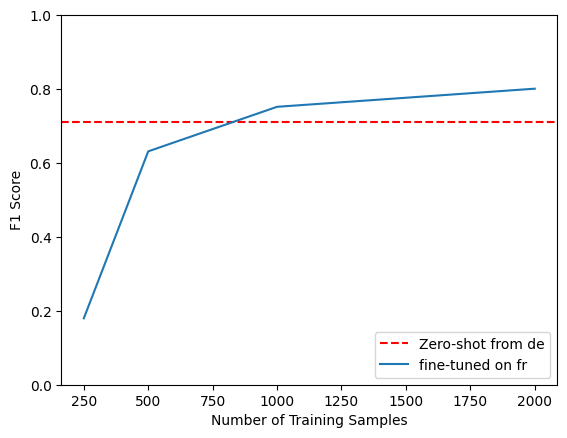

In [201]:
fig,ax=plt.subplots()

ax.axhline(f1_scores['de']['fr'],ls='--',color='r')
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de","fine-tuned on fr"],loc='lower right')
plt.ylim((0,1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

In [203]:
from datasets import concatenate_datasets
def concatenate_splits(corpora):
    multi_corpus=DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split]=concatenate_datasets([corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

panx_de_fr_encoded=concatenate_splits([panx_de_encoded,panx_fr_encoded])

In [205]:
training_args = replace(training_args,logging_steps=len(panx_de_fr_encoded['train'])//batch_size )
training_args = replace(training_args,push_to_hub=True)
training_args = replace(training_args,output_dir="xlm-roberta-base-finetuned-panx-de-fr")



trainer=Trainer(
    model_init=model_init
    ,args=training_args
    ,data_collator=data_collator
    ,compute_metrics=compute_metrics
    ,tokenizer=xlmr_tokenizer
    ,train_dataset=panx_de_fr_encoded['train']
    ,eval_dataset=panx_de_fr_encoded['validation']
    )

trainer.train()
trainer.push_to_hub('Training completed')

Epoch,Training Loss,Validation Loss,F1
1,0.305900,0.189366,0.816879
2,0.148000,0.166267,0.847342
3,0.093200,0.166879,0.860351


compute_metrics eval predictions:[[[ 3.3527243e+00 -8.6132205e-01 -1.3202717e+00 ... -1.9380438e-01
   -8.1522655e-01 -2.8109345e+00]
  [ 8.1673794e+00 -1.0574957e+00 -1.5664294e+00 ... -9.9615908e-01
   -1.6810232e+00 -4.0458889e+00]
  [ 8.4255409e+00 -1.6909134e+00 -1.4968333e+00 ... -1.5357221e+00
   -1.4050546e+00 -4.3656359e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 4.1298094e+00 -1.7776082e+00 -1.3805302e+00 ...  1.5577512e+00
    1.5715243e+00 -4.2667594e+00]
  [ 6.7596169e+00 -6.1181569e-01 -7.7673739e-01 ... -2.2972022e-01
   -1.5546205e+00 -4.7689962e+00]
  [ 6.3014488e+00 -6.5720421e-01 -7.7049643e-01 ... -3.7661964e-01
   -1.5954905e+00 -4.2895994e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

'https://huggingface.co/ckandemir/xlm-roberta-base-finetuned-panx-de-fr/tree/main/'

In [207]:
corpora=[panx_de_encoded]
for lang in langs[1:]:
    training_args = replace(training_args,output_dir=f"xlm-roberta-base-finetuned-panx-[lang]")
    #fine-tune on monolingual corpus
    ds_encoded=encode_panx_dataset(panx_ch[lang])
    metrics=train_on_subset(ds_encoded,ds_encoded['train'].num_rows)

    # Collect F1-Scores in common dict
    f1_scores[lang][lang]=metrics['f1_score'][0]

    corpora.append(ds_encoded)

Epoch,Training Loss,Validation Loss,F1
1,0.576300,0.337649,0.787727
2,0.263500,0.274654,0.831826
3,0.176200,0.269272,0.841805


compute_metrics eval predictions:[[[ 1.88677654e-01 -2.48002410e-01 -7.00037241e-01 ...  3.15647751e-01
    3.77424583e-02 -6.89697385e-01]
  [-5.78213573e-01  2.62862587e+00 -2.29439974e+00 ...  4.03336477e+00
   -2.24559617e+00 -2.66706371e+00]
  [-8.96816730e-01 -2.54975647e-01  6.31080210e-01 ...  3.66754860e-01
    1.24798846e+00 -3.00091267e+00]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[ 2.76412070e-03 -4.45290685e-01 -7.77660370e-01 ...  6.62922263e-02
    1.93402722e-01 -6.28729105e-01]
  [ 6.60552406e+00 -1.28973389e+00 -1.17487955e+00 ... -2.59047896e-01
   -1.58122122e+00 -3.44021964e+00]
  [ 6.01835060e+00 -1.24758220e+00 -1.03320920e+00 ... -3.58118147e-01
   -1.29357374e+00 -3.51216865e+

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

compute_metrics eval predictions:[[[ 9.1601944e-01  1.3230221e+00  1.2899560e+00 ... -8.4806943e-01
   -6.7183101e-01 -1.6651119e+00]
  [ 7.5570722e+00 -1.1146128e+00 -8.8513368e-01 ... -1.2381837e+00
   -1.6192946e+00 -3.3056943e+00]
  [ 7.6195850e+00 -1.0753139e+00 -1.0152317e+00 ... -1.3116124e+00
   -1.6162465e+00 -3.3964198e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 1.0925393e+00  1.2596630e-02 -5.7587355e-01 ...  5.8909672e-01
   -1.7622033e-01 -1.8194289e+00]
  [ 6.4115143e+00 -9.6388197e-01 -2.7046341e-01 ... -8.0861712e-01
   -1.8290467e+00 -3.3091521e+00]
  [ 6.2845292e+00 -1.2505521e+00 -7.3814243e-03 ... -9.6665001e-01
   -1.2419425e+00 -3.3823440e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,F1
1,0.834500,0.338253,0.727056
2,0.296200,0.261880,0.807661
3,0.202000,0.247405,0.811429


compute_metrics eval predictions:[[[ 1.20807409e+00 -7.11940527e-01 -1.01169968e+00 ...  4.47665036e-01
    3.86904091e-01 -8.38818073e-01]
  [ 6.05790901e+00 -1.81386065e+00 -1.23584843e+00 ... -1.12540394e-01
   -1.31489873e+00 -3.70760345e+00]
  [ 6.03007364e+00 -2.30197811e+00 -1.20061612e+00 ... -5.86159110e-01
   -1.20223987e+00 -3.66724753e+00]
  ...
  [ 1.38003695e+00 -7.73994386e-01 -1.03451848e+00 ...  4.84270811e-01
    5.05078554e-01 -9.48122978e-01]
  [ 1.38003695e+00 -7.73994386e-01 -1.03451848e+00 ...  4.84270811e-01
    5.05078554e-01 -9.48122978e-01]
  [ 1.38003695e+00 -7.73994386e-01 -1.03451848e+00 ...  4.84270811e-01
    5.05078554e-01 -9.48122978e-01]]

 [[ 1.68709755e+00 -5.01423120e-01 -7.81328440e-01 ...  4.24209088e-02
   -2.10450321e-01 -9.03218925e-01]
  [ 6.91828203e+00 -1.73717904e+00 -6.93036318e-01 ... -1.25610268e+00
   -1.16410351e+00 -3.55495358e+00]
  [ 7.03921700e+00 -1.80929255e+00 -5.53714812e-01 ... -1.22641563e+00
   -1.16040707e+00 -3.60428762e+

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

compute_metrics eval predictions:[[[ 2.6055861e+00 -6.8031454e-01 -6.6080666e-01 ... -1.7980680e-02
   -4.3563074e-01 -1.1052933e+00]
  [ 7.6234388e+00 -1.3063854e+00 -5.0271893e-01 ... -1.0656540e+00
   -1.7896162e+00 -3.5846949e+00]
  [ 7.4972572e+00 -1.3910234e+00 -5.2414834e-01 ... -1.0831157e+00
   -1.8240492e+00 -3.6423259e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 3.8432851e+00 -6.3515186e-01 -3.0839503e-01 ...  1.5788414e-01
    3.9889380e-02 -1.4002053e+00]
  [ 7.6840205e+00 -1.2620018e+00 -4.2130196e-01 ... -9.5252502e-01
   -1.6183420e+00 -3.4550376e+00]
  [ 7.5108738e+00 -1.3481737e+00 -6.4323440e-02 ... -1.1641977e+00
   -1.3774756e+00 -3.2807987e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

Epoch,Training Loss,Validation Loss,F1
1,1.108500,0.568709,0.557940
2,0.500100,0.418559,0.678116
3,0.353500,0.390215,0.699324


compute_metrics eval predictions:[[[ 1.9199699e-02 -2.8325778e-01 -7.9131752e-01 ...  2.4078685e-01
   -9.7391002e-02 -3.7859046e-01]
  [ 5.6352119e+00 -1.6830243e+00 -4.2936200e-01 ... -1.8969581e+00
   -8.6766088e-01 -3.3985810e+00]
  [ 4.3542070e+00 -1.0134758e+00 -5.2847785e-01 ... -1.2071106e+00
   -7.0010728e-01 -3.4147744e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 1.9344513e-01 -3.7904990e-01 -7.9376704e-01 ...  2.7308214e-01
    3.2095954e-02 -4.9573889e-01]
  [ 6.2752438e+00 -1.5620939e+00 -6.6213489e-01 ... -1.4838932e+00
   -6.8945211e-01 -3.2835748e+00]
  [ 4.8347578e+00 -1.1067562e+00 -3.2506365e-01 ... -1.0641682e+00
   -3.0604190e-01 -2.9385617e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

compute_metrics eval predictions:[[[ 3.22879076e-01 -3.20554137e-01 -8.91942859e-01 ...  3.21609259e-01
   -1.79174960e-01 -4.38337862e-01]
  [ 7.15014124e+00 -1.70409036e+00 -9.52884197e-01 ... -1.35513234e+00
   -1.07988143e+00 -3.63892269e+00]
  [ 7.03551006e+00 -1.78244531e+00 -8.91882539e-01 ... -1.15509307e+00
   -9.03374970e-01 -3.65668774e+00]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[-1.73624292e-01 -8.33965540e-02 -6.53411329e-01 ...  3.51848304e-01
   -1.83781296e-01 -3.80590409e-01]
  [-6.36352897e-01  5.44559193e+00 -3.49341124e-01 ...  4.98306334e-01
   -2.94135141e+00 -2.04302311e+00]
  [-9.93969738e-01  2.79377133e-01  5.18877935e+00 ... -1.82003820e+00
   -1.03035247e+00 -2.99710321e+

In [208]:
corpora_encoded=concatenate_splits(corpora)

In [210]:
training_args = replace(training_args,logging_steps=len(corpora_encoded['train'])//batch_size)
training_args = replace(training_args,output_dir="xlm-roberta-base-finetuned-panx-all")


trainer=Trainer(
    model_init=model_init
    ,args=training_args
    ,data_collator=data_collator
    ,compute_metrics=compute_metrics
    ,tokenizer=xlmr_tokenizer
    ,train_dataset=corpora_encoded['train']
    ,eval_dataset=corpora_encoded['validation']
    )

trainer.train()
trainer.push_to_hub('Training completed')

Epoch,Training Loss,Validation Loss,F1
1,0.301800,0.195176,0.812061
2,0.157500,0.177562,0.840392
3,0.101700,0.172347,0.854885


compute_metrics eval predictions:[[[ 4.1224999e+00  3.6458328e-01 -1.6324927e+00 ...  7.1841407e-01
   -7.6478910e-01 -4.1426287e+00]
  [ 8.0788746e+00 -1.2858362e+00 -1.2653993e+00 ... -1.6064374e+00
   -7.2686535e-01 -3.9887567e+00]
  [ 8.3486052e+00 -1.6108729e+00 -1.3290082e+00 ... -1.7872570e+00
   -6.0828018e-01 -4.3844676e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 1.2099391e+00 -1.0283861e+00 -1.2955836e+00 ...  7.7715403e-01
    1.1131364e+00 -1.8495200e+00]
  [ 9.5718205e-01  4.9327222e-01 -2.9354186e+00 ...  4.7255583e+00
   -7.6939619e-01 -3.1230609e+00]
  [ 1.6528232e+00 -2.4505577e+00 -1.7736454e+00 ...  1.9823565e+00
    3.1630421e+00 -4.6307073e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

'https://huggingface.co/ckandemir/xlm-roberta-base-finetuned-panx-all/tree/main/'

In [211]:
for idx, lang in enumerate(langs):
    f1_scores['all'][lang]=get_f1_score(trainer,corpora[idx]['test'])

scores_data={
    'de':f1_scores['de'],
    'each':{lang: f1_scores[lang][lang] for lang in langs},
    'all':f1_scores['all']
             }

f1_scores_df=pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on",columns='Evaluated on', inplace=True)

f1_scores_df

compute_metrics eval predictions:[[[ 3.8007388e-01 -2.6016667e+00 -3.9230597e-01 ...  8.2663512e-01
    4.3362169e+00 -3.1348972e+00]
  [ 9.1403303e+00 -1.5759118e+00 -1.7339402e+00 ... -1.2080991e+00
   -1.9706334e+00 -3.4372311e+00]
  [ 8.9502048e+00 -1.6542263e+00 -1.6591525e+00 ... -1.3441412e+00
   -1.8028252e+00 -3.4585721e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 3.4843259e+00  6.9807053e-01  5.4422721e-02 ... -1.3729047e+00
   -2.1107769e+00 -3.2720785e+00]
  [ 9.3137741e+00 -1.5162983e+00 -1.3602400e+00 ... -1.9740868e+00
   -1.8196129e+00 -3.6559024e+00]
  [-2.0677791e+00  6.4130239e+00 -8.6361611e-01 ... -1.9147077e-01
   -3.4829841e+00 -2.5522203e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

compute_metrics eval predictions:[[[  -0.16328835    1.1398182     1.2538352  ...   -0.31369516
     -0.68938255   -1.9370031 ]
  [   8.106105     -0.65477014   -0.8535411  ...   -2.1535618
     -2.954205     -4.238394  ]
  [   8.1463       -0.9377662    -0.6372958  ...   -2.3938723
     -2.5032387    -4.314543  ]
  ...
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]]

 [[   3.638656     -1.1199615    -1.4925498  ...    1.5720477
      0.16719072   -2.8901086 ]
  [   7.9524255    -1.3071172    -1.5850656  ...   -0.37555248
     -2.459854     -3.9406674 ]
  [   8.147516     -1.5288224    -1.5068105  ...   -0.51380956
     -1.9229443    -4.209566  ]
  ...
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]
  [-100.         -100.         -100.  

compute_metrics eval predictions:[[[ 3.5857577e+00 -1.5215082e+00 -1.5597012e+00 ...  4.3227077e-02
   -2.4095836e-01 -3.2701681e+00]
  [ 9.0539684e+00 -1.5788518e+00 -1.8617735e+00 ... -1.6277738e+00
   -1.7523476e+00 -3.6786356e+00]
  [ 8.9193497e+00 -1.7623253e+00 -1.7464379e+00 ... -1.6901747e+00
   -1.7165227e+00 -3.9759691e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 4.7723560e+00 -1.7812309e+00 -1.9463300e+00 ...  1.0067904e+00
    5.0257587e-01 -3.2160156e+00]
  [ 9.2204437e+00 -1.8542356e+00 -1.9531583e+00 ... -1.1128825e+00
   -1.8776779e+00 -3.8010132e+00]
  [ 9.1737423e+00 -2.3183846e+00 -1.6587908e+00 ... -1.5984052e+00
   -1.3206623e+00 -3.7030444e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

compute_metrics eval predictions:[[[ 5.3726792e+00 -8.4649301e-01 -1.9791026e+00 ...  1.3071352e-01
   -1.5893468e+00 -3.2269571e+00]
  [ 9.1922989e+00 -2.0064688e+00 -1.8268526e+00 ... -2.0151658e+00
   -1.4568470e+00 -3.8521788e+00]
  [ 9.1246929e+00 -2.1981688e+00 -1.7755579e+00 ... -1.9644287e+00
   -1.3188163e+00 -4.1069641e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 1.8898473e+00  7.1028137e-01  8.4348261e-01 ... -2.2910669e-01
   -1.5755234e+00 -2.8097844e+00]
  [-1.3379292e+00  8.0050049e+00 -1.0213548e+00 ... -4.6391502e-01
   -3.5341768e+00 -2.4372098e+00]
  [-1.6603549e+00 -7.0264101e-02  7.3961959e+00 ... -2.5420196e+00
   -1.1177862e+00 -2.8872330e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8635,0.7110,0.6954,0.5837
each,0.8635,0.8444,0.8127,0.7008
all,0.8654,0.8553,0.8610,0.7704


# From these results we can draw a few general conclusion:
- Multilingual learning can provide significant gains in performance, especially if the low-resource langauges for cross-lingual transfer bleong to similar language families.
    - In our experiemnts we can see that German, French, and Italian acheive similar perforance in the **all** category, suggesting these languages are more similar to each other than to English

- As a general strategy, it is a good idea to focus attention on cross-lingual transfer within language families, especially when dealing with different scripts like Japanese

In [212]:
from google.colab import runtime

runtime.unassign()

In [ ]:
x